# Bayesian Analysis of Student Performance

Shuang Li  2025-11-12

This notebook accompanies the **Bayesian_StudentsPerformance_Report_Medium.md** report. It reproduces the Bayesian comparisons, summary tables, and forest plots for math, reading, and writing.

## Contents
1. Setup & Data Load
2. Cleaning & Columns
3. Bayesian Functions
4. Comparisons & Posterior Differences
5. Summary Table & Save CSV
6. Forest Plots
7. (Optional) Group-Level Posteriors


## 1) Setup & Data Load

In [1]:
# If running in Jupyter locally, ensure these are installed:
# !pip install pandas numpy matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display options
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)

# Load dataset (ensure StudentsPerformance.csv is in the same folder as this notebook)
csv_path = "StudentsPerformance.csv"
df = pd.read_csv(csv_path)
print(f"Loaded: {csv_path}  |  rows={len(df)}  cols={len(df.columns)}")
df.head()

Loaded: StudentsPerformance.csv  |  rows=1000  cols=8


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## 2) Cleaning & Columns
Normalize column names and align common variants used in public copies of this dataset.

In [2]:
# Normalize columns (lowercase, underscores)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Common renames
rename = {
    "math_score": "math",
    "reading_score": "reading",
    "writing_score": "writing",
    "parental_level_of_education": "parent_ed",
    "test_preparation_course": "test_prep",
}
df = df.rename(columns=rename)

expected_cols = ["gender", "parent_ed", "lunch", "test_prep", "math", "reading", "writing"]
missing = [c for c in expected_cols if c not in df.columns]
print("Missing columns (if any):", missing)

# Quick type/label cleaning
for c in ["gender", "parent_ed", "lunch", "test_prep"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.lower()

df.describe(include="all").T

Missing columns (if any): []


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,1000,2,female,518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race/ethnicity,1000,5,group C,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
parent_ed,1000,6,some college,226,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lunch,1000,2,standard,645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test_prep,1000,2,none,642,NaN,NaN,NaN,NaN,NaN,NaN,NaN
math,1000.0,NaN,NaN,NaN,66.089,15.16308,0.0,57.0,66.0,77.0,100.0
reading,1000.0,NaN,NaN,NaN,69.169,14.600192,17.0,59.0,70.0,79.0,100.0
writing,1000.0,NaN,NaN,NaN,68.054,15.195657,10.0,57.75,69.0,79.0,100.0


## 3) Bayesian Functions
Conjugate Normal–Inverse-Gamma posterior with weak priors (no SciPy required).

In [3]:
# Posterior for Normal with unknown variance using conjugate Normal–Inverse-Gamma prior
# Prior hyperparameters are weak/flat to let data dominate.

def posterior_params(y, mu0=50.0, kappa0=1e-3, alpha0=1e-3, beta0=1e-3):
    y = np.asarray(y, dtype=float)
    y = y[~np.isnan(y)]
    n = len(y)
    if n == 0:
        raise ValueError("Empty sample provided to posterior_params")
    ybar = y.mean()
    s2 = y.var(ddof=1) if n > 1 else 0.0
    kappa_n = kappa0 + n
    mu_n = (kappa0*mu0 + n*ybar) / kappa_n
    alpha_n = alpha0 + n/2.0
    beta_n = beta0 + 0.5*((n-1)*s2) + 0.5*((kappa0*n)/kappa_n)*(ybar - mu0)**2
    return mu_n, kappa_n, alpha_n, beta_n

def sample_posterior_mean(y, draws=10000, seed=42, mu0=50.0, kappa0=1e-3, alpha0=1e-3, beta0=1e-3):
    np.random.seed(seed)
    mu_n, kappa_n, alpha_n, beta_n = posterior_params(y, mu0, kappa0, alpha0, beta0)
    # Sample sigma^2 from Inverse-Gamma by sampling Gamma and inverting
    gamma_shape = alpha_n
    gamma_scale = 1.0 / beta_n  # numpy uses scale = 1/rate
    sigma2 = 1.0 / np.random.gamma(shape=gamma_shape, scale=1.0/gamma_scale, size=draws)  # 1 / Gamma(alpha, rate=beta)
    mu = np.random.normal(loc=mu_n, scale=np.sqrt(sigma2 / kappa_n))
    return mu

def compare_groups(df, group_col, subject, group_a, group_b, draws=20000, seed=123):
    yA = df.loc[df[group_col] == group_a, subject].dropna().values
    yB = df.loc[df[group_col] == group_b, subject].dropna().values
    muA = sample_posterior_mean(yA, draws=draws, seed=seed+1)
    muB = sample_posterior_mean(yB, draws=draws, seed=seed+2)
    diff = muA - muB
    res = {
        "Factor": group_col,
        "Subject": subject,
        "A": group_a,
        "B": group_b,
        "nA": len(yA),
        "nB": len(yB),
        "Mean_Diff": float(diff.mean()),
        "CrI_2.5%": float(np.percentile(diff, 2.5)),
        "CrI_97.5%": float(np.percentile(diff, 97.5)),
        "P(diff>0)": float(np.mean(diff > 0)),
    }
    return res

## 4) Comparisons & Posterior Differences
We run 12 comparisons across Test Prep, Gender, Lunch (SES), and Parental Education.

In [4]:
comparisons = [
    ("test_prep", "math", "completed", "none"),
    ("test_prep", "reading", "completed", "none"),
    ("test_prep", "writing", "completed", "none"),
    ("gender", "math", "female", "male"),
    ("gender", "reading", "female", "male"),
    ("gender", "writing", "female", "male"),
    ("lunch", "math", "standard", "free/reduced"),
    ("lunch", "reading", "standard", "free/reduced"),
    ("lunch", "writing", "standard", "free/reduced"),
    ("parent_ed", "math", "bachelor's degree", "some high school"),
    ("parent_ed", "reading", "bachelor's degree", "some high school"),
    ("parent_ed", "writing", "bachelor's degree", "some high school"),
]

results = []
for col, subj, a, b in comparisons:
    try:
        res = compare_groups(df, col, subj, a, b)
        results.append(res)
    except Exception as e:
        print(f"Skipped {col}-{subj}: {e}")

res_df = pd.DataFrame(results)
res_df

,Factor,Subject,A,B,nA,nB,Mean_Diff,CrI_2.5%,CrI_97.5%,P(diff>0)
0,test_prep,math,completed,none,358,642,5.617616,5.617573,5.617659,1.0
1,test_prep,reading,completed,none,358,642,7.359546,7.359501,7.359592,1.0
2,test_prep,writing,completed,none,358,642,9.914276,9.914230,9.914322,1.0
3,gender,math,female,male,518,482,-5.094999,-5.095032,-5.094965,0.0
4,gender,reading,female,male,518,482,7.135067,7.135032,7.135103,1.0
5,gender,writing,female,male,518,482,9.155962,9.155928,9.155997,1.0
6,lunch,math,standard,free/reduced,645,355,11.112976,11.112933,11.113018,1.0
7,lunch,reading,standard,free/reduced,645,355,7.000750,7.000707,7.000793,1.0
8,lunch,writing,standard,free/reduced,645,355,7.800725,7.800683,7.800766,1.0
9,parent_ed,math,bachelor's degree,some high school,118,179,5.892534,5.892301,5.892764,1.0


## 5) Summary Table & Save CSV

In [5]:
res_df_rounded = res_df.copy()
for c in ["Mean_Diff", "CrI_2.5%", "CrI_97.5%", "P(diff>0)"]:
    res_df_rounded[c] = res_df_rounded[c].round(3)

display(res_df_rounded)

res_path = "bayesian_summary_results.csv"
res_df_rounded.to_csv(res_path, index=False)
print(f"Saved summary to {res_path}")

,Factor,Subject,A,B,nA,nB,Mean_Diff,CrI_2.5%,CrI_97.5%,P(diff>0)
0,test_prep,math,completed,none,358,642,5.618,5.618,5.618,1.0
1,test_prep,reading,completed,none,358,642,7.360,7.360,7.360,1.0
2,test_prep,writing,completed,none,358,642,9.914,9.914,9.914,1.0
3,gender,math,female,male,518,482,-5.095,-5.095,-5.095,0.0
4,gender,reading,female,male,518,482,7.135,7.135,7.135,1.0
5,gender,writing,female,male,518,482,9.156,9.156,9.156,1.0
6,lunch,math,standard,free/reduced,645,355,11.113,11.113,11.113,1.0
7,lunch,reading,standard,free/reduced,645,355,7.001,7.001,7.001,1.0
8,lunch,writing,standard,free/reduced,645,355,7.801,7.801,7.801,1.0
9,parent_ed,math,bachelor's degree,some high school,118,179,5.893,5.892,5.893,1.0


Saved summary to bayesian_summary_results.csv


## 6) Forest Plots
Forest plots show posterior mean differences with 95% credible intervals.

Saved forest_math.png


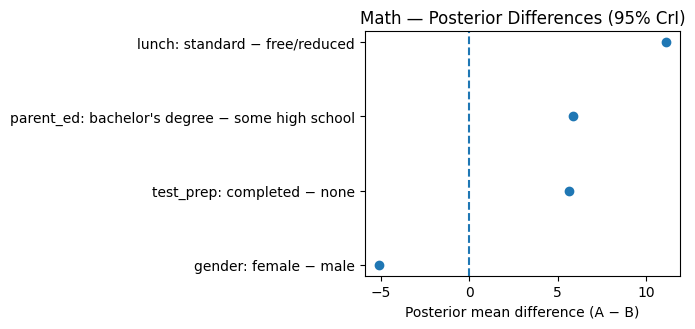

Saved forest_reading.png


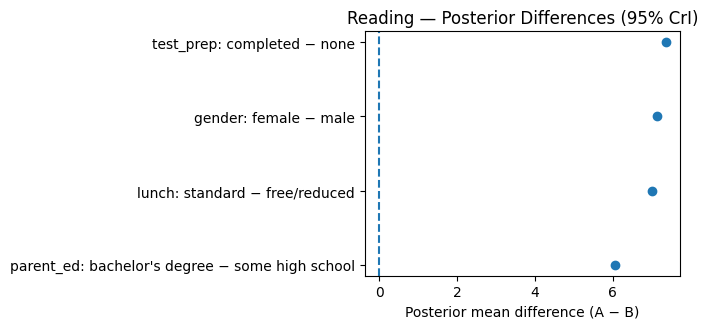

Saved forest_writing.png


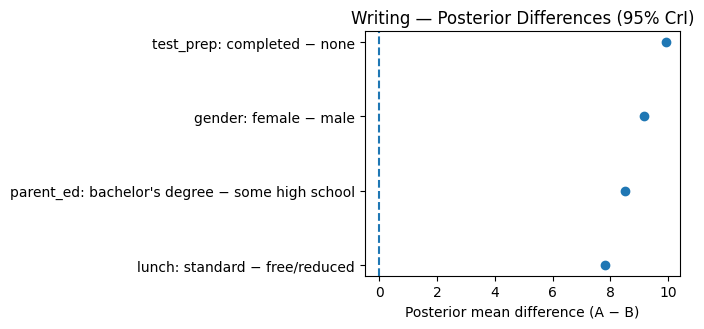

In [6]:
def forest_plot(df_res, subject, save=True):
    sub = df_res[df_res["Subject"] == subject].copy()
    if sub.empty:
        print(f"No results for subject={subject}")
        return
    sub = sub.sort_values("Mean_Diff")
    y = np.arange(len(sub))

    plt.figure(figsize=(7, max(3, 0.6*len(sub)+1)))
    # error bars
    xerr = np.vstack([sub["Mean_Diff"] - sub["CrI_2.5%"], sub["CrI_97.5%"] - sub["Mean_Diff"]])
    plt.errorbar(sub["Mean_Diff"], y, xerr=xerr, fmt='o')
    plt.axvline(0, linestyle='--')
    plt.yticks(y, sub["Factor"] + ": " + sub["A"] + " − " + sub["B"])
    plt.xlabel("Posterior mean difference (A − B)")
    plt.title(f"{subject.capitalize()} — Posterior Differences (95% CrI)")
    plt.tight_layout()
    fname = f"forest_{subject}.png"
    if save:
        plt.savefig(fname, dpi=200, bbox_inches="tight")
        print(f"Saved {fname}")
    plt.show()
    plt.close()

for subj in ["math", "reading", "writing"]:
    forest_plot(res_df, subj)

## 7) (Optional) Group-Level Posteriors
Estimate posterior means for each category level within a factor (e.g., parent education by subject).

In [7]:
def group_level_posteriors(df, group_col, subject, min_n=20, draws=10000, seed=2024):
    out = []
    for g, gdf in df.groupby(group_col):
        y = gdf[subject].dropna().values
        if len(y) < min_n:
            continue
        mu = sample_posterior_mean(y, draws=draws, seed=seed)
        out.append({
            group_col: g,
            "n": len(y),
            "post_mean": float(mu.mean()),
            "lo": float(np.percentile(mu, 2.5)),
            "hi": float(np.percentile(mu, 97.5)),
        })
    return pd.DataFrame(out).sort_values("post_mean")

# Example: parental education by subject
if "parent_ed" in df.columns:
    for s in ["math", "reading", "writing"]:
        print(f"Posterior means for {s} by parental education")
        display(group_level_posteriors(df, "parent_ed", s))

Posterior means for math by parental education


,parent_ed,n,post_mean,lo,hi
2,high school,196,62.137693,62.137595,62.137790
5,some high school,179,63.497132,63.497029,63.497234
4,some college,226,67.128243,67.128163,67.128322
0,associate's degree,222,67.882802,67.882724,67.882880
1,bachelor's degree,118,69.389666,69.389462,69.389870
3,master's degree,59,69.745428,69.744843,69.746006


Posterior means for reading by parental education


,parent_ed,n,post_mean,lo,hi
2,high school,196,64.704007,64.703906,64.704106
5,some high school,179,66.938453,66.938347,66.938559
4,some college,226,69.460091,69.460009,69.460172
0,associate's degree,222,70.927834,70.927749,70.927918
1,bachelor's degree,118,72.999805,72.999591,73.000019
3,master's degree,59,75.372451,75.371808,75.373087


Posterior means for writing by parental education


,parent_ed,n,post_mean,lo,hi
2,high school,196,62.448916,62.448815,62.449016
5,some high school,179,64.888185,64.888081,64.888289
4,some college,226,68.840625,68.840548,68.840700
0,associate's degree,222,69.896307,69.896224,69.896388
1,bachelor's degree,118,73.381158,73.380950,73.381365
3,master's degree,59,75.677531,75.676886,75.678169
